# Optimize latent code, _w_, for real image

### Steps
1. Initialize _w_ with the average on a number of _w_ from _z_ s
2. Forward _w_ to generate real image _x_
3. Back propagate gradient from the loss, MSE
4. Repeat step 2 and 3 for 1000 iteration

In [2]:
# imports

import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from functools import partial
from model import StyledGenerator
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [3]:
# load styled generator

resolution = 256
step = int(math.log(resolution, 2)) - 2
device = 'cuda'
ckpt_path = f'checkpoint/stylegan-{resolution}px-new.model'

styled_generator = StyledGenerator()
styled_generator.load_state_dict(torch.load(ckpt_path)['g_running'])
styled_generator.to(device)
styled_generator.eval()
print(f"Loading trained generator for {resolution}px")
print(f"Succesfully loaded the generator to {device}")

Loading trained generator for 256px
Succesfully loaded the generator to cuda


In [4]:
# take synthesis generator

synthesis_generator = styled_generator.generator

In [5]:
# get average w
latent = torch.randn((1024, 512)).to(device)

avg_w = styled_generator.mean_style(latent).detach()

### Prepare Real Face Data

We will use samples from CelebA dataset.

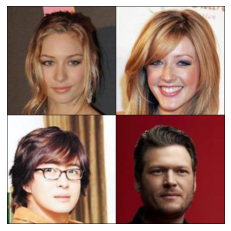

In [6]:
# get samples of celeb_a dataset

celeb_a_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(resolution),
    transforms.CenterCrop(resolution),
    transforms.Normalize(0, 1)
])
celeb_a = ImageFolder('data/celeb_a/', transform=celeb_a_transforms)
celeb_a_loader = DataLoader(celeb_a, batch_size=4)
imgs, _ = next(iter(celeb_a_loader))
imgs = torchvision.utils.make_grid(imgs, nrow=2, padding=1, normalize=True)

# plot the samples
plt.axis('off')
plt.imshow(imgs.permute(1, 2, 0))

### Loss function with pixelwise MSE
Measure the loss with mean squared difference of each pixel. 
This is a general approach but will have difficulty maintaining high frequency features.
Thus, ther result of optimized latent code may generate blurred images

In [10]:
# train w on the sample

def generate_noise(num_sample, step, device='cpu'):
    noise = []
    
    for i in range(step + 1):
        size = 4 * 2 ** i
        noise.append(torch.randn(num_sample, 1, size, size, device=device))
#         noise.append(torch.zeros(num_sample, 1, size, size, device=device))
        
    return noise

def generate_img(w, noise, step):
    imgs = synthesis_generator([w], noise, step=step)
    return imgs


In [6]:

num_itr = 1000
num_sample = 4
w = avg_w.expand(num_sample, 512).clone()
w.requires_grad = True

criterion = nn.MSELoss()
optimizer = optim.Adam([w], lr=0.1)

real_imgs, _ = next(iter(celeb_a_loader))
real_imgs = real_imgs.to(device)

losses = []
img_progress = []

begin_time = time.time()
elapsed_time = time.time()
for itr in range(num_itr):
    optimizer.zero_grad()
    noise = generate_noise(num_sample, step, device)
    pred_imgs = generate_img(w, noise, step)
    
    loss = criterion(pred_imgs, real_imgs)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if (itr + 1) % int(num_itr / 10) == 0:
        print(f"Loss: {round(loss.item(), 5)}")
        print(f"Time elapsed: {time.time() - elapsed_time}s")
        elapsed_time = time.time()
        pred_imgs = pred_imgs.cpu().detach()
#         pred_imgs_normalized = (pred_imgs - pred_imgs.mean()) / pred_imgs.var()
        pred_imgs_normalized = (pred_imgs - pred_imgs.min()) / (pred_imgs.max() - pred_imgs.min())
        img_progress.append(pred_imgs_normalized)
end_time = time.time()

print(f"Total time spent: {end_time - begin_time}")

Loss: 0.01465
Time elapsed: 9.572973012924194s
Loss: 0.00957
Time elapsed: 8.989436388015747s
Loss: 0.00754
Time elapsed: 9.00723934173584s
Loss: 0.00649
Time elapsed: 9.008983135223389s
Loss: 0.00593
Time elapsed: 9.018677473068237s
Loss: 0.00538
Time elapsed: 9.047058343887329s
Loss: 0.0052
Time elapsed: 9.086779832839966s
Loss: 0.00502
Time elapsed: 9.041529178619385s
Loss: 0.00484
Time elapsed: 9.13205361366272s
Loss: 0.00468
Time elapsed: 9.196493148803711s
Total time spent: 91.1052143573761


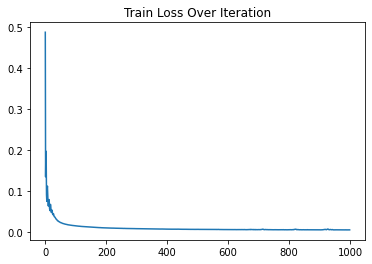

In [7]:
plt.title("Train Loss Over Iteration")
plt.plot(losses)

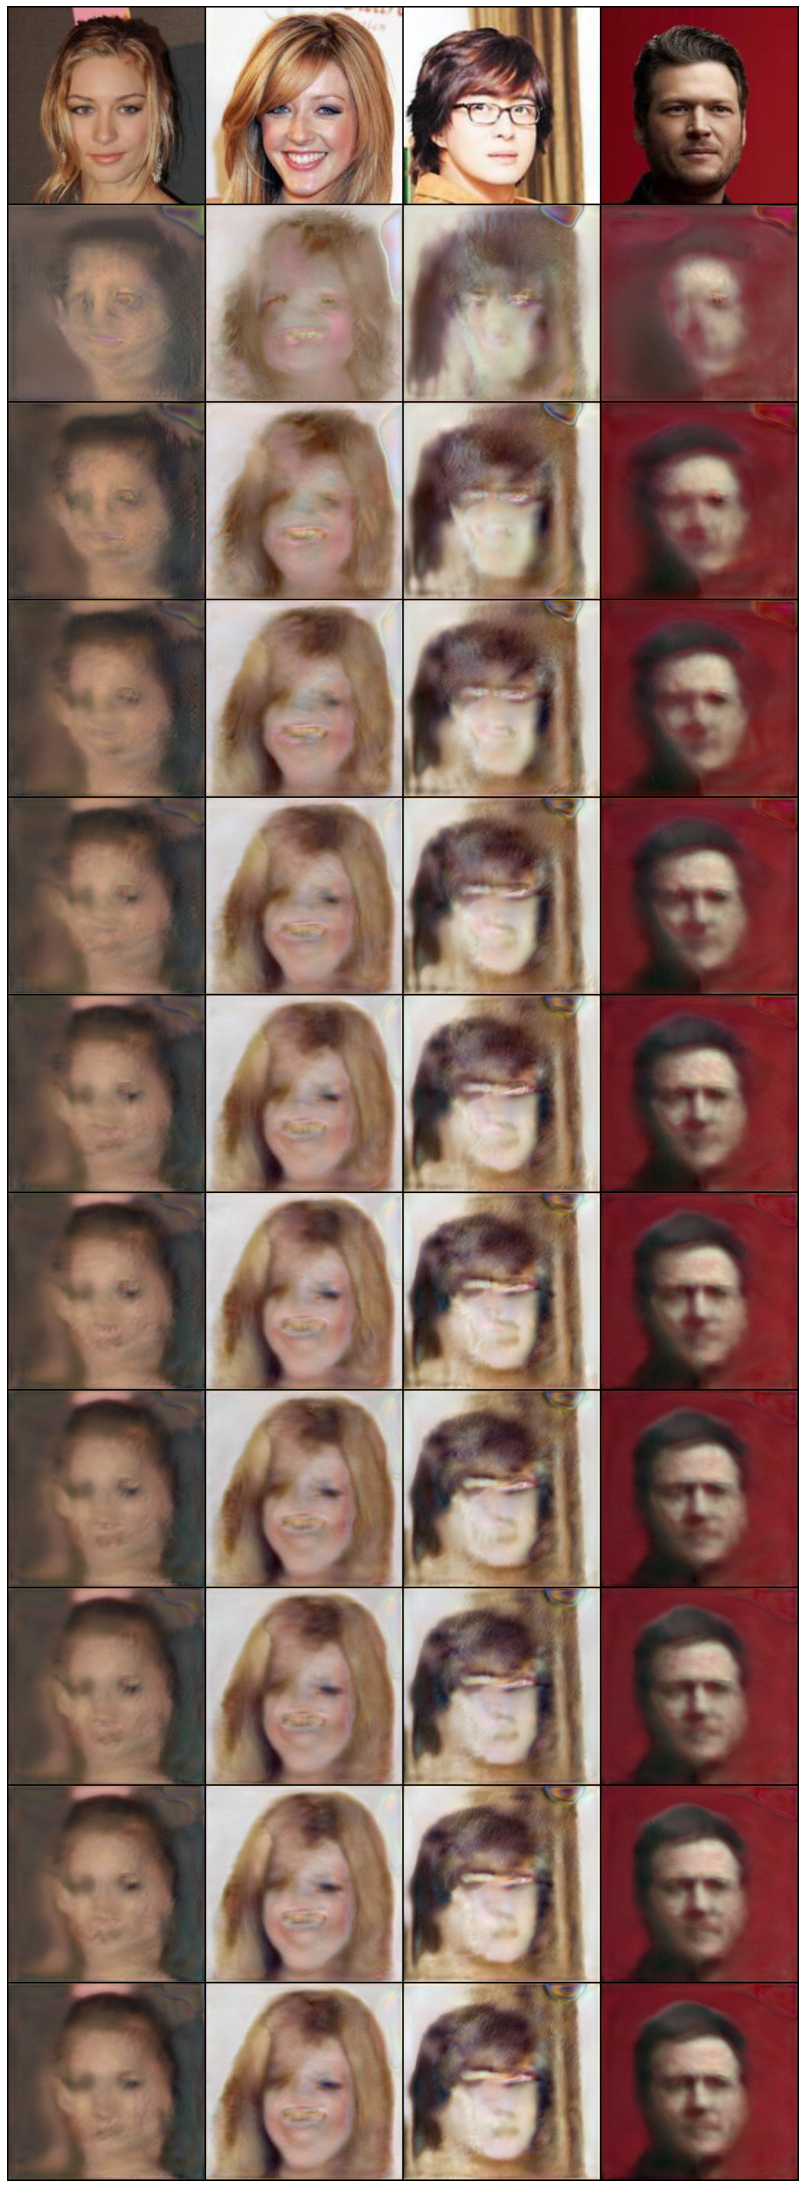

In [8]:
real_imgs = real_imgs.cpu()
img_progress.insert(0, real_imgs)

progression = torch.cat(img_progress, dim=0)
progression = torchvision.utils.make_grid(progression, nrow=num_sample, normalize=False)

# plt.rcParams['figure.figsize'] = [20, 20]
plt.figure(figsize=(20, 40))
plt.axis('off')
plt.imshow(progression.permute(1, 2, 0))
plt.savefig('encoder_progress_1.png', dpi=50)

### Style mixing with the optimized latent code
I tried implementing style mixing with the optimized latent code of real images.
However, maybe due to the poor image quality missing fine features, the result looks awful.

In [9]:
@torch.no_grad()
def style_mixing(styles, noise, step):
    progression_A = []
    progression_B = []
    
    for i in range(step):
        img = synthesis_generator(styles, noise, step=step, mixing_range=(0, i))
        progression_A.append(img.cpu())
    for i in range(step):
        img = synthesis_generator(styles, noise, step=step, mixing_range=(step - i, step))
        progression_B.append(img.cpu())
    return progression_A, progression_B


In [10]:
noise = generate_noise(1, step, device)
i, j = 0, 1
styles = [w[i: i + 1], w[j: j + 1]]
prog_A, prog_B = style_mixing(styles, noise, step)

img_i, img_j = real_imgs[i: i + 1], real_imgs[j: j + 1]
prog_A.insert(0, img_i)
prog_B.insert(0, img_i)
prog_A.append(img_j)
prog_B.append(img_j)

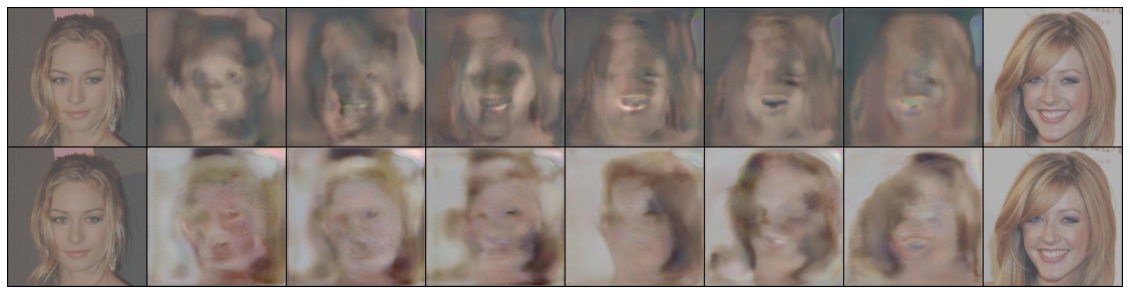

In [11]:
prog_A = torch.cat(prog_A, dim=0)
prog_B = torch.cat(prog_B, dim=0)
prog = torch.cat([prog_A, prog_B], dim=0)
prog_img = torchvision.utils.make_grid(prog, nrow=(step + 2), normalize=True)

plt.figure(figsize=(20, 40))
plt.axis('off')
plt.imshow(prog_img.permute(1, 2, 0))
plt.savefig('style_mixing.png', dpi=50)

In [7]:
# use VGG network to train

vgg16 = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True)
vgg16_feature_extractor = vgg16.features[:14]
vgg16_feature_extractor.eval()
vgg16_feature_extractor.to(device)
print(f"VGG 16 successfully loaded to {device}")

Using cache found in C:\Users\vulco/.cache\torch\hub\pytorch_vision_v0.9.0


VGG 16 successfully loaded to cuda


In [13]:
# same as before but add VGG network to it

num_itr = 1000
num_sample = 4
w = avg_w.expand(num_sample, 512).clone()
w.requires_grad = True

criterion = nn.MSELoss()
optimizer = optim.Adam([w], lr=0.1)

real_imgs, _ = next(iter(celeb_a_loader))
real_imgs = real_imgs.to(device)
# add VGG here
real_features = vgg16_feature_extractor(real_imgs).detach()

losses = []
img_progress = []

begin_time = time.time()
elapsed_time = time.time()
for itr in range(num_itr):
    optimizer.zero_grad()
    noise = generate_noise(num_sample, step, device)
    pred_imgs = generate_img(w, noise, step)
    # add VGG here
    pred_features = vgg16_feature_extractor(pred_imgs)
    
    # adjust accordingly
    loss = criterion(pred_features, real_features)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if (itr + 1) % int(num_itr / 10) == 0:
        print(f"Loss: {round(loss.item(), 5)}")
        print(f"Time elapsed: {time.time() - elapsed_time}s")
        elapsed_time = time.time()
        pred_imgs = pred_imgs.cpu().detach()
#         pred_imgs_normalized = (pred_imgs - pred_imgs.mean()) / pred_imgs.var()
        pred_imgs_normalized = (pred_imgs - pred_imgs.min()) / (pred_imgs.max() - pred_imgs.min())
        img_progress.append(pred_imgs_normalized)
end_time = time.time()

print(f"Total time spent: {end_time - begin_time}")

C:\Users\vulco\miniconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Loss: 1.74074
Time elapsed: 11.710225105285645s
Loss: 1.58982
Time elapsed: 11.718165636062622s
Loss: 1.51247
Time elapsed: 11.726658344268799s
Loss: 1.47053
Time elapsed: 11.72178840637207s
Loss: 1.44467
Time elapsed: 11.709351301193237s
Loss: 1.40872
Time elapsed: 11.735573053359985s
Loss: 1.38496
Time elapsed: 11.93041729927063s
Loss: 1.3667
Time elapsed: 11.78417444229126s
Loss: 1.35609
Time elapsed: 11.728698253631592s
Loss: 1.32607
Time elapsed: 11.749329090118408s
Total time spent: 117.51737403869629


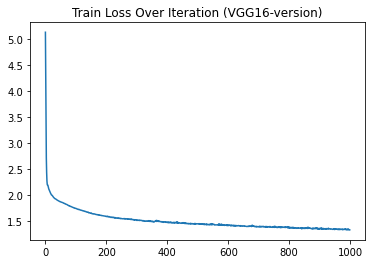

In [14]:
plt.title("Train Loss Over Iteration (VGG16-version)")
plt.plot(losses)

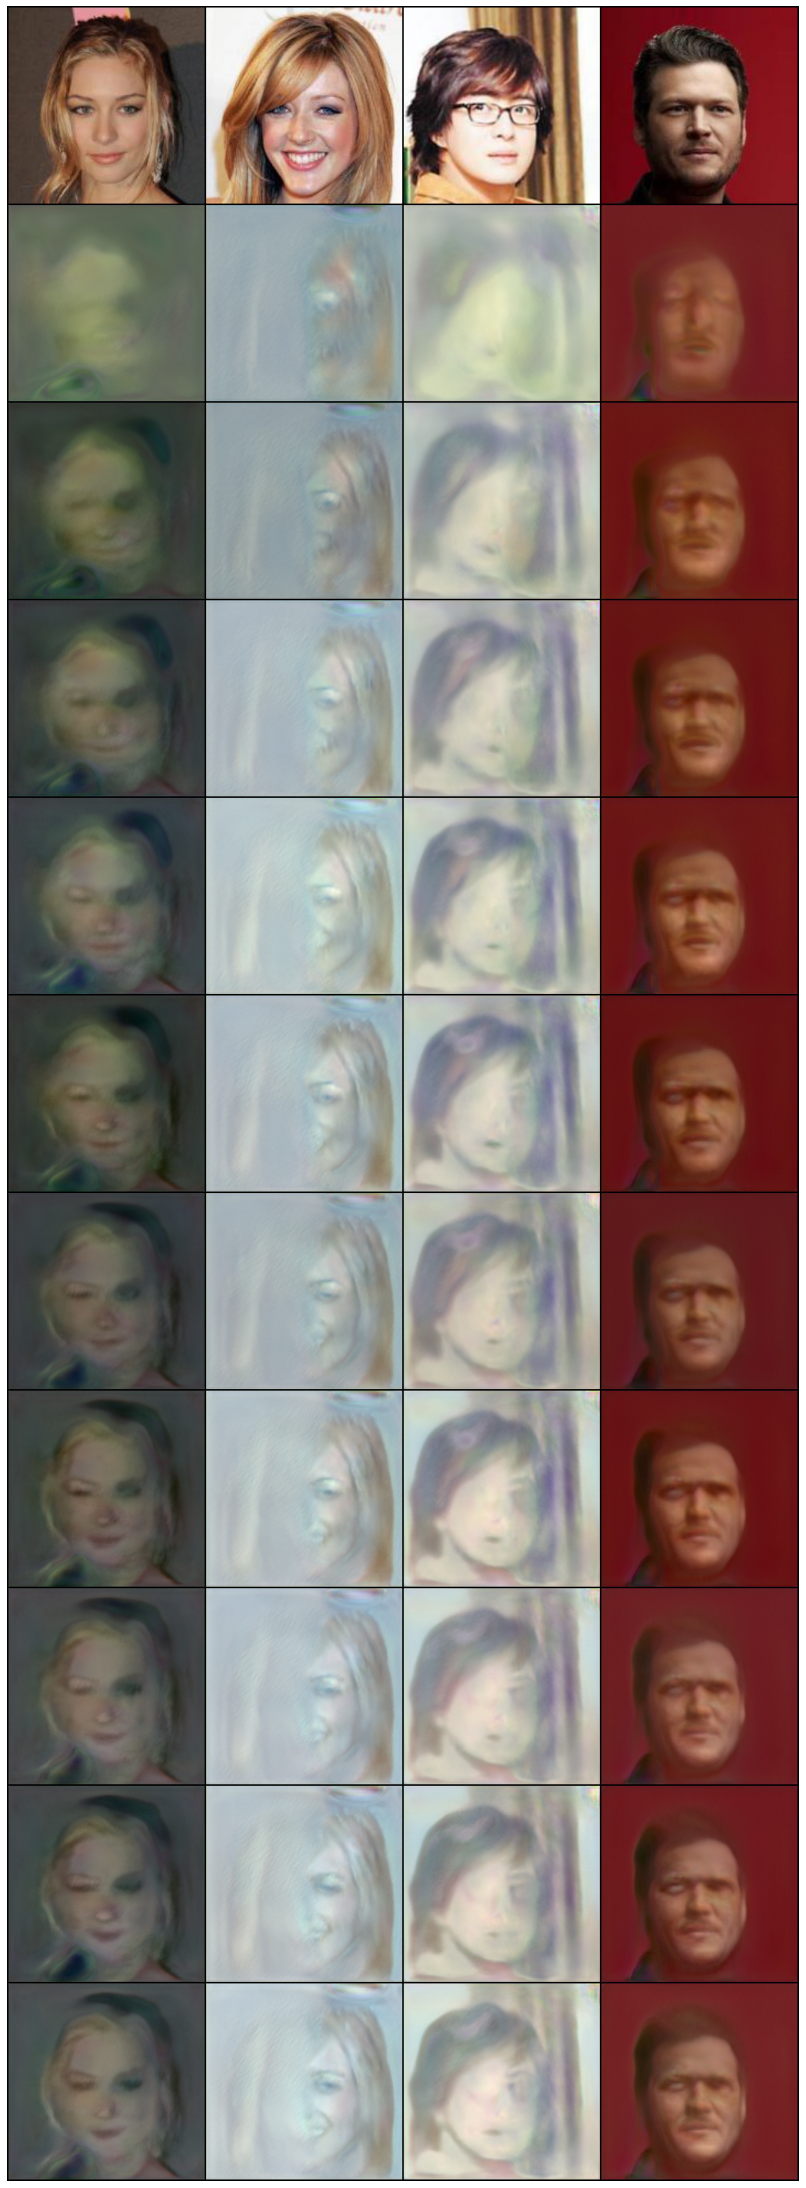

In [15]:
real_imgs = real_imgs.cpu()
img_progress.insert(0, real_imgs)

progression = torch.cat(img_progress, dim=0)
progression = torchvision.utils.make_grid(progression, nrow=num_sample, normalize=False)

# plt.rcParams['figure.figsize'] = [20, 20]
plt.figure(figsize=(20, 40))
plt.axis('off')
plt.imshow(progression.permute(1, 2, 0))
plt.savefig('encoder_progress_2.png', dpi=50)

### VGG Loss + MSE Loss?
This is an experiment of mixing two loss function throughout optimization.
Starting with MSE loss, it linearly becomes VGG loss
The idea here is to capture general structure of a real image and then to capture fine features.

$$ Loss_{tot}(w) = (1 - \alpha) \times Loss_{VGG}(w) + \alpha \times Loss_{MSE}(w) $$

In [11]:
# same as before but loss that consider both pixel by pixel loss and feature loss

num_itr = 2000
num_sample = 4
w = avg_w.expand(num_sample, 512).clone()
w.requires_grad = True

criterion = nn.MSELoss()
optimizer = optim.Adam([w], lr=0.1)

real_imgs, _ = next(iter(celeb_a_loader))
real_imgs = real_imgs.to(device)
# add VGG here
real_features = vgg16_feature_extractor(real_imgs).detach()

losses = []
img_progress = []

begin_time = time.time()
elapsed_time = time.time()
for itr in range(num_itr):
    optimizer.zero_grad()
    noise = generate_noise(num_sample, step, device)
    pred_imgs = generate_img(w, noise, step)
    alpha = itr / num_itr
    
#     # add VGG here
#     if itr > num_itr / 2:
#         pred_features = vgg16_feature_extractor(pred_imgs)
#         feature_loss = criterion(pred_features, real_features)
#         pixel_loss = 0
#     else:
#         feature_loss = 0
#         pixel_loss = criterion(pred_imgs, real_imgs)
    pred_features = vgg16_feature_extractor(pred_imgs)
    feature_loss = criterion(pred_features, real_features)
    pixel_loss = criterion(pred_imgs, real_imgs)
    
    # new loss function
    loss = (1 - alpha) * pixel_loss + alpha * feature_loss
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if (itr + 1) % int(num_itr / 10) == 0:
        print(f"Loss: {round(loss.item(), 5)}")
        print(f"Time elapsed: {time.time() - elapsed_time}s")
        elapsed_time = time.time()
        
        pred_imgs = pred_imgs.cpu().detach()
#         pred_imgs_normalized = (pred_imgs - pred_imgs.mean()) / pred_imgs.var()
        pred_imgs_normalized = (pred_imgs - pred_imgs.min()) / (pred_imgs.max() - pred_imgs.min())
        img_progress.append(pred_imgs_normalized)
end_time = time.time()

print(f"Total time spent: {end_time - begin_time}")

Loss: 0.16091
Time elapsed: 22.948885440826416s
Loss: 0.27513
Time elapsed: 22.885267734527588s
Loss: 0.38473
Time elapsed: 22.952747583389282s
Loss: 0.48766
Time elapsed: 23.00153923034668s
Loss: 0.59448
Time elapsed: 23.040029287338257s
Loss: 0.71264
Time elapsed: 23.06490397453308s
Loss: 0.82657
Time elapsed: 23.041547060012817s
Loss: 0.92049
Time elapsed: 23.042147397994995s
Loss: 1.02302
Time elapsed: 23.058555841445923s
Loss: 1.16686
Time elapsed: 23.04840660095215s
Total time spent: 230.0860254764557


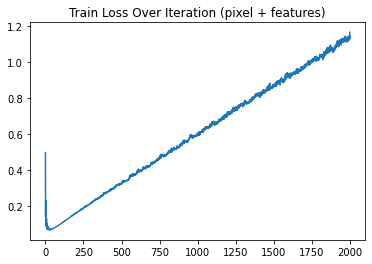

In [12]:
plt.title("Train Loss Over Iteration (pixel + features)")
plt.plot(losses)

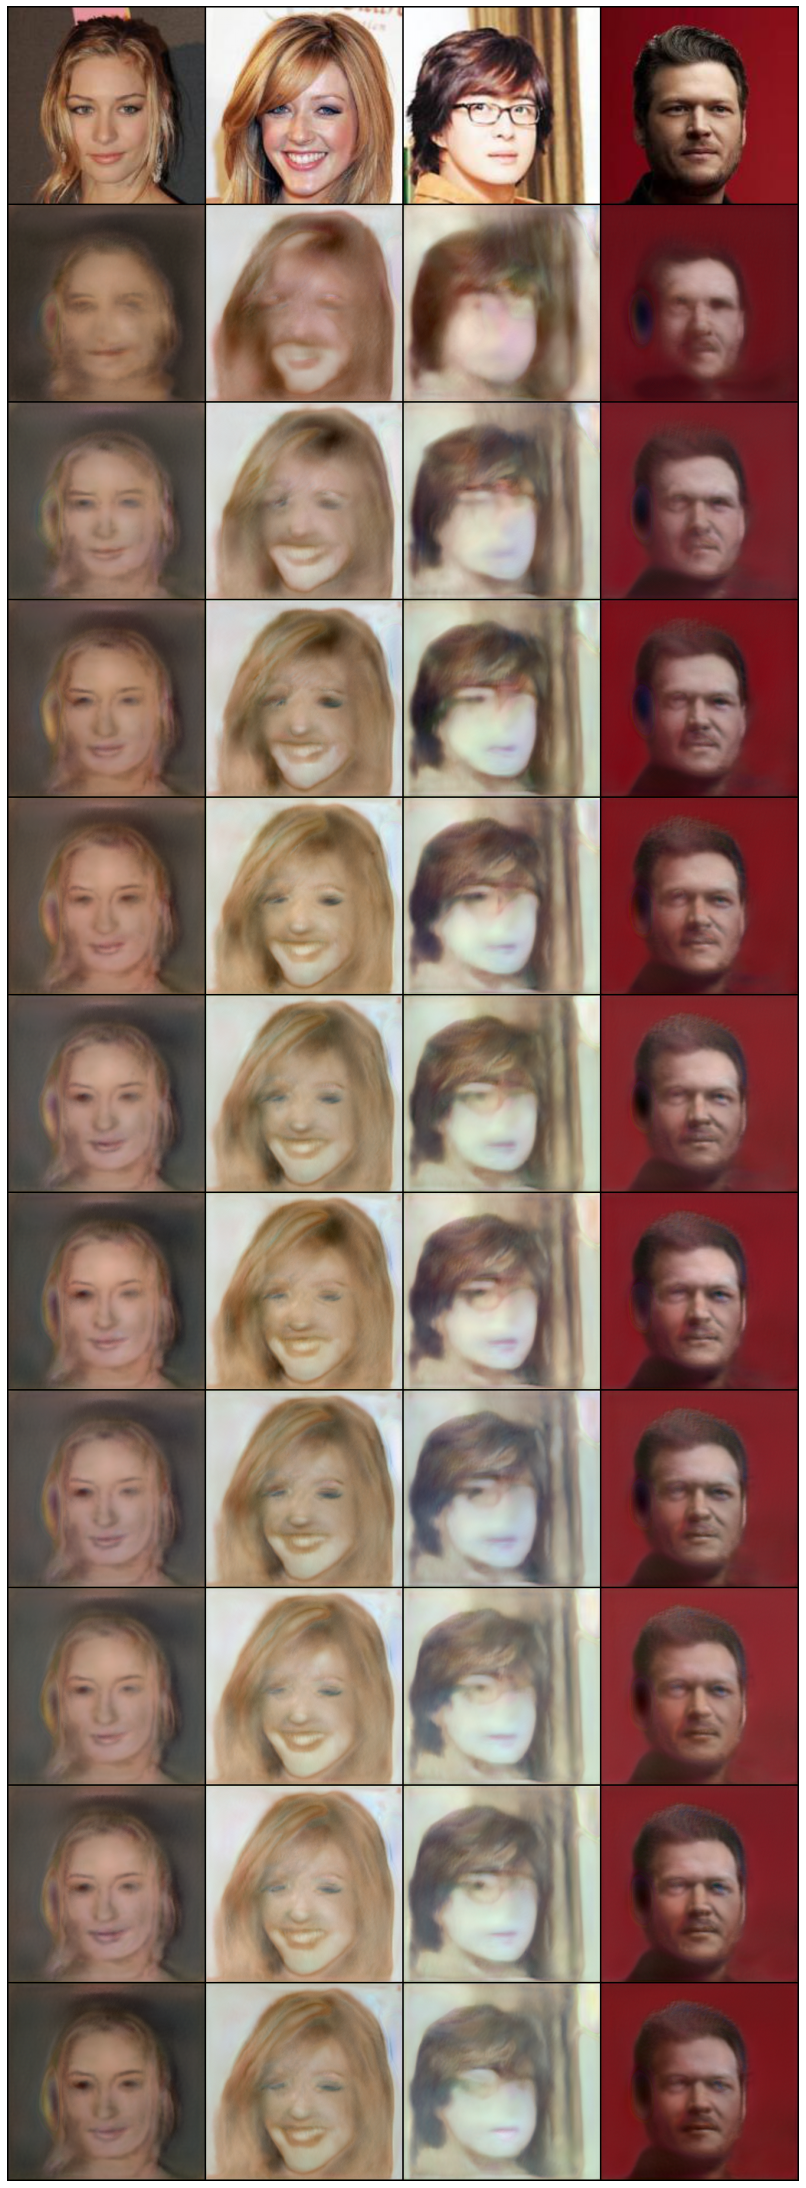

In [13]:
real_imgs = real_imgs.cpu()
img_progress.insert(0, real_imgs)

progression = torch.cat(img_progress, dim=0)
progression = torchvision.utils.make_grid(progression, nrow=num_sample, normalize=False)

# plt.rcParams['figure.figsize'] = [20, 20]
plt.figure(figsize=(20, 40))
plt.axis('off')
plt.imshow(progression.permute(1, 2, 0))

plt.savefig('encoder_progress_3.png', dpi=50)

In [14]:
noise = generate_noise(1, step, device)
i, j = 0, 1
styles = [w[i: i + 1], w[j: j + 1]]
prog_A, prog_B = style_mixing(styles, noise, step)

img_i, img_j = real_imgs[i: i + 1], real_imgs[j: j + 1]
prog_A.insert(0, img_i)
prog_B.insert(0, img_i)
prog_A.append(img_j)
prog_B.append(img_j)

prog_A = torch.cat(prog_A, dim=0)
prog_B = torch.cat(prog_B, dim=0)
prog = torch.cat([prog_A, prog_B], dim=0)
prog_img = torchvision.utils.make_grid(prog, nrow=(step + 2), normalize=True)

plt.figure(figsize=(20, 40))
plt.axis('off')
plt.imshow(prog_img.permute(1, 2, 0))
plt.savefig('style_mixing.png', dpi=50)

NameError: name 'style_mixing' is not defined